In [1]:
import os
import json

from zipfile import ZipFile
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
kaggle_dictionary=json.load(open("kaggle.json"))

In [3]:
os.environ["KAGGLE_USERNAME"]= kaggle_dictionary["username"]
os.environ["KAGGLE_KEY"]= kaggle_dictionary["key"]

In [4]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
with ZipFile("imdb-dataset-of-50k-movie-reviews.zip","r") as zip_ref:
    zip_ref.extractall()

In [6]:
data=pd.read_csv("IMDB Dataset.csv")

In [7]:
data.shape

(50000, 2)

In [8]:
data["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [9]:
pd.set_option('future.no_silent_downcasting', True)
data.replace({"sentiment":{"positive":1,"negative":0}},inplace=True)

In [10]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [11]:
train_data, test_data=train_test_split(data,test_size=0.25,random_state=43)

#,stratify=data['sentiment'].values

In [12]:
print(train_data.shape)
print(test_data.shape)

(37500, 2)
(12500, 2)


In [13]:
#uses lementization

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shivaram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shivaram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/shivaram/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shivaram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
lemmatizer = WordNetLemmatizer()

In [30]:
train_data_l=train_data
test_data_l=test_data

In [31]:
def lemmatize_review(review):
    words=word_tokenize(review)
    lemmatized_review=' '.join(lemmatizer.lemmatize(word, pos='v') for word in words)
    return lemmatized_review

train_data_l['lemmatized_review'] = train_data['review'].apply(lemmatize_review)
test_data_l['lemmatized_review'] = test_data['review'].apply(lemmatize_review)

In [32]:
#remove stopwords

from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

train_data_l['lemmatized_review'] = train_data_l['lemmatized_review'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shivaram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data_l['lemmatized_review'])

In [34]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data['lemmatized_review']), maxlen=200)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data['lemmatized_review']), maxlen=200)

In [35]:
x_train

array([[   0,    0,    0, ...,   15, 1121, 1903],
       [ 109,    5, 1739, ...,    1,    3, 3110],
       [   0,    0,    0, ...,  545,    9, 2372],
       ...,
       [   0,    0,    0, ...,  104,   44,  515],
       [   0,    0,    0, ...,   35,   25,  777],
       [   0,    0,    0, ...,    6,   38,  144]], dtype=int32)

In [36]:
y_train=train_data["sentiment"]
y_test=test_data["sentiment"]

In [37]:
y_train = np.array(y_train.astype(int))
y_test = np.array(y_test.astype(int))

In [38]:
print(y_train)

[0 0 0 ... 1 1 0]


In [39]:
model=Sequential()
model.add(Embedding(input_dim=5000,output_dim=128))
model.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation="sigmoid"))

In [40]:
model.build(input_shape=(None, 200))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771,713 (2.94 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [43]:
history=model.fit(x_train,y_train,epochs=10,batch_size=64,validation_split=0.2)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 101s 216ms/step - accuracy: 0.8304 - loss: 0.3952 - val_accuracy: 0.8797 - val_loss: 0.3014
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 120s 256ms/step - accuracy: 0.8908 - loss: 0.2770 - val_accuracy: 0.8744 - val_loss: 0.3085
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 119s 254ms/step - accuracy: 0.9101 - loss: 0.2327 - val_accuracy: 0.8825 - val_loss: 0.2985
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 133s 285ms/step - accuracy: 0.9217 - loss: 0.2025 - val_accuracy: 0.8768 - val_loss: 0.3321
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 303ms/step - accuracy: 0.9326 - loss: 0.1799 - val_accuracy: 0.8832 - val_loss: 0.3151
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 132s 281ms/step - accuracy: 0.9408 - loss: 0.1588 - val_accuracy: 0.8784 - val_loss: 0.3354
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 128s 272ms/step - accuracy: 0.9519 - loss: 0.1336 - val_accuracy: 0.8825 - val_loss: 0.3811
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 243ms/step - accuracy: 0.9601 -

In [44]:
loss,accuracy=model.evaluate(x_test,y_test)
print(f"Test Loss: {loss}\nTest Accuracy: {accuracy}")

391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.7844 - loss: 0.8371
Test Loss: 0.839500367641449
Test Accuracy: 0.783840000629425


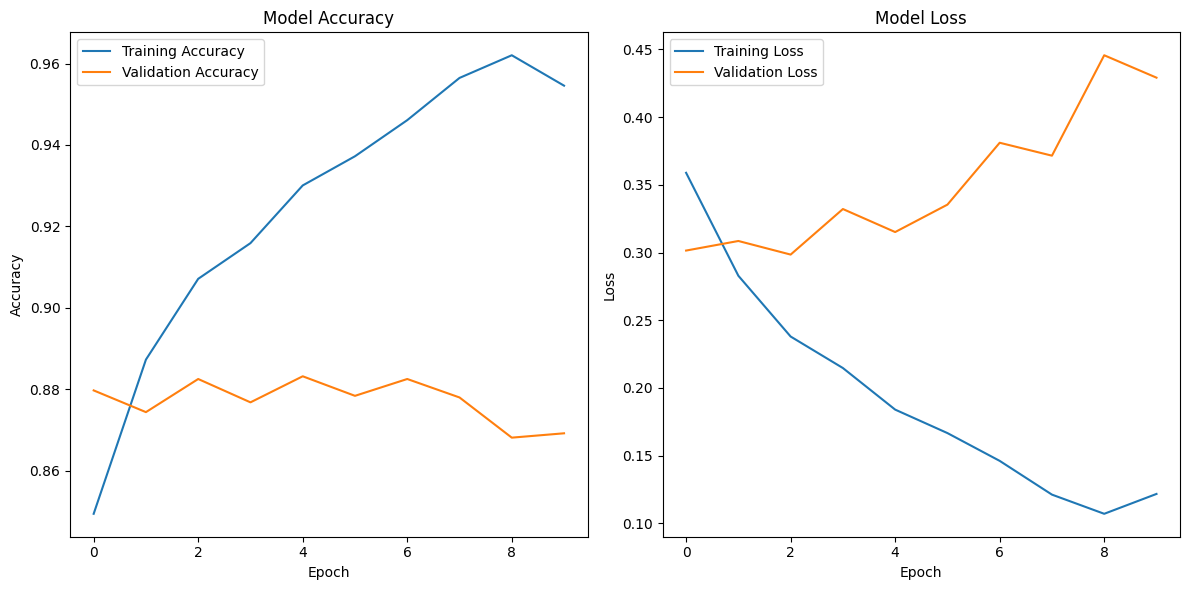

In [45]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [46]:
from sklearn.metrics import classification_report

y_pred = (model.predict(x_test) > 0.5).astype("int32")

report = classification_report(y_test, y_pred, target_names=['negative', 'positive'])

print(report)

391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step
              precision    recall  f1-score   support

    negative       0.93      0.61      0.74      6248
    positive       0.71      0.96      0.82      6252

    accuracy                           0.78     12500
   macro avg       0.82      0.78      0.78     12500
weighted avg       0.82      0.78      0.78     12500



In [47]:
def lemmatize_review(review):
    words = review.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words 

In [48]:
def predict_sentiment(review):
    lemmantized_review=lemmatize_review(review)
    sequence = tokenizer.texts_to_sequences([' '.join(lemmantized_review)])
    padded_sequence = pad_sequences(sequence, maxlen=200)
    predictions = model.predict(padded_sequence)
    sentiment = "positive" if predictions[0][0] > 0.5 else "negative"
    print(predictions[0][0])
    return sentiment

In [49]:
test_reviews = [
    "I absolutely loved this movie! It was great.",
    "The movie was okay, but not the best.",
    "This movie was fantastic. I loved it.",
    "I hated this film. It was terrible.",
    "This movie was not so good.",
    "What a fantastic story! I couldn't stop watching.",
]

for review in test_reviews:
    sentiment = predict_sentiment(review)
    print(f"Review: '{review}'\nSentiment: {sentiment}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0.9992299
Review: 'I absolutely loved this movie! It was great.'
Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.06527622
Review: 'The movie was okay, but not the best.'
Sentiment: negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0.9944359
Review: 'This movie was fantastic. I loved it.'
Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0.0032900714
Review: 'I hated this film. It was terrible.'
Sentiment: negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.33734944
Review: 'This movie was not so good.'
Sentiment: negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0.016663518
Review: 'What a fantastic story! I couldn't stop watching.'
Sentiment: negative



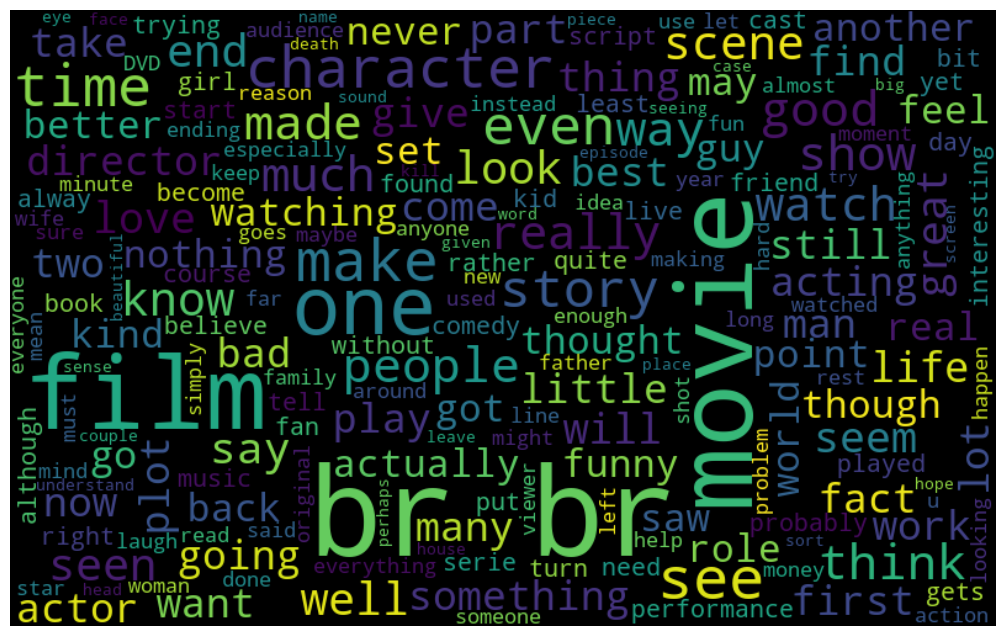

In [50]:
# visualize the frequent words

from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = " ".join([sentence for sentence in train_data['review']])

wordcloud = WordCloud(width=800, height=500, random_state=43, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()